Neste notebooke exercitei a a criação de uma rede neural para predizer se o paciente tem ou não diabetes. O data set empregado foi o Pima Indians Diabetes Database, disponível no Kaggle (https://www.kaggle.com/uciml/pima-indians-diabetes-database.)


---



---



In [0]:
#importando pacotes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import Normalizer
from keras.layers import Activation, Dense, Dropout, BatchNormalization, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
%matplotlib inline
plt.style.use('fivethirtyeight')


In [7]:
# Importanto csv para o colab

from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
# lendo o dataset 

diabetes = pd.read_csv('/content/gdrive/My Drive/diabetes.csv')
diabetes.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0




---



---



## Análises exploratórias

-----------------------

In [11]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


O data set não possui missing data

In [12]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [14]:
diabetes.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


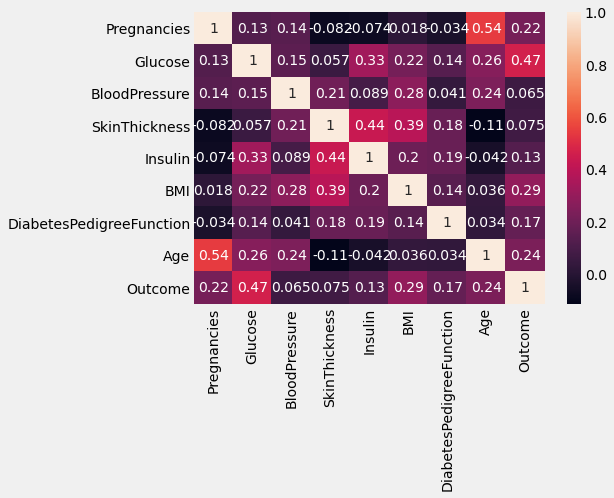

In [19]:
f, ax = plt.subplots(1, figsize=(7,5))
sns.heatmap(diabetes.corr(), annot=True, ax=ax)

Os níveis de glicose são os que mais influenciam no resultado final.

In [21]:
column_names = diabetes.columns
column_names = column_names.drop('Outcome')
for name in column_names:
    print('{}\n'.format(name))
    print(diabetes.groupby(['Outcome'])[name].mean())
    print('*'*50)
    print()

Pregnancies

Outcome
0    3.298000
1    4.865672
Name: Pregnancies, dtype: float64
**************************************************

Glucose

Outcome
0    109.980000
1    141.257463
Name: Glucose, dtype: float64
**************************************************

BloodPressure

Outcome
0    68.184000
1    70.824627
Name: BloodPressure, dtype: float64
**************************************************

SkinThickness

Outcome
0    19.664000
1    22.164179
Name: SkinThickness, dtype: float64
**************************************************

Insulin

Outcome
0     68.792000
1    100.335821
Name: Insulin, dtype: float64
**************************************************

BMI

Outcome
0    30.304200
1    35.142537
Name: BMI, dtype: float64
**************************************************

DiabetesPedigreeFunction

Outcome
0    0.429734
1    0.550500
Name: DiabetesPedigreeFunction, dtype: float64
**************************************************

Age

Outcome
0    31.190000
1    37.067

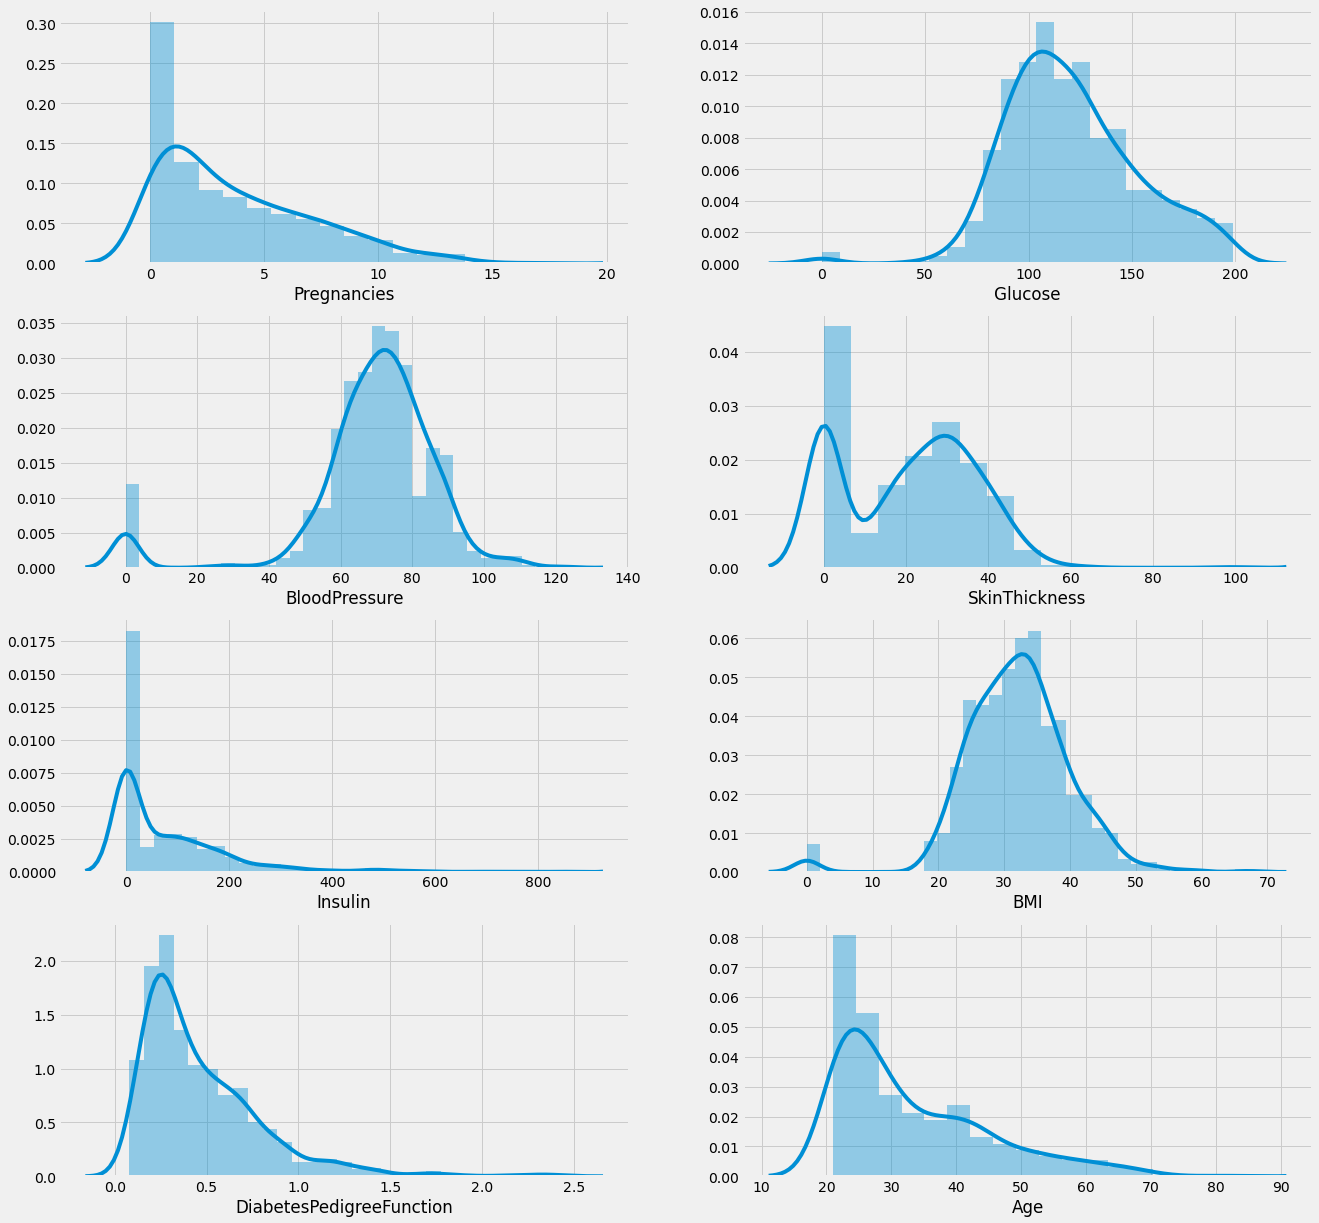

In [25]:
f, axes = plt.subplots(4,2, figsize=(20,20))
sns.distplot(diabetes.Pregnancies, ax=axes[0,0])
sns.distplot(diabetes.Glucose, ax=axes[0,1])
sns.distplot(diabetes.BloodPressure, ax=axes[1,0])
sns.distplot(diabetes.SkinThickness, ax=axes[1,1])
sns.distplot(diabetes.Insulin, ax=axes[2,0])
sns.distplot(diabetes.BMI, ax=axes[2,1])
sns.distplot(diabetes.DiabetesPedigreeFunction, ax=axes[3,0])
sns.distplot(diabetes.Age, ax=axes[3,1])

Neste conjunto de dados, as pessoas diagnosticadas com diabetes apresentaram valores médios mais altos para cada atributo.



---



---



In [0]:
#Substituindo 0 pelo valor médio em Skin Thickness, Insulin, Blood Pressure, Glucose e BMI
diabetes.SkinThickness.replace(0, diabetes.SkinThickness.median(), inplace=True)
diabetes.Insulin.replace(0, diabetes.Insulin.median(), inplace=True)
diabetes.Glucose.replace(0, diabetes.Glucose.median(), inplace=True)
diabetes.BloodPressure.replace(0, diabetes.BloodPressure.median(), inplace=True)
diabetes.BMI.replace(0, diabetes.BMI.median(), inplace=True)

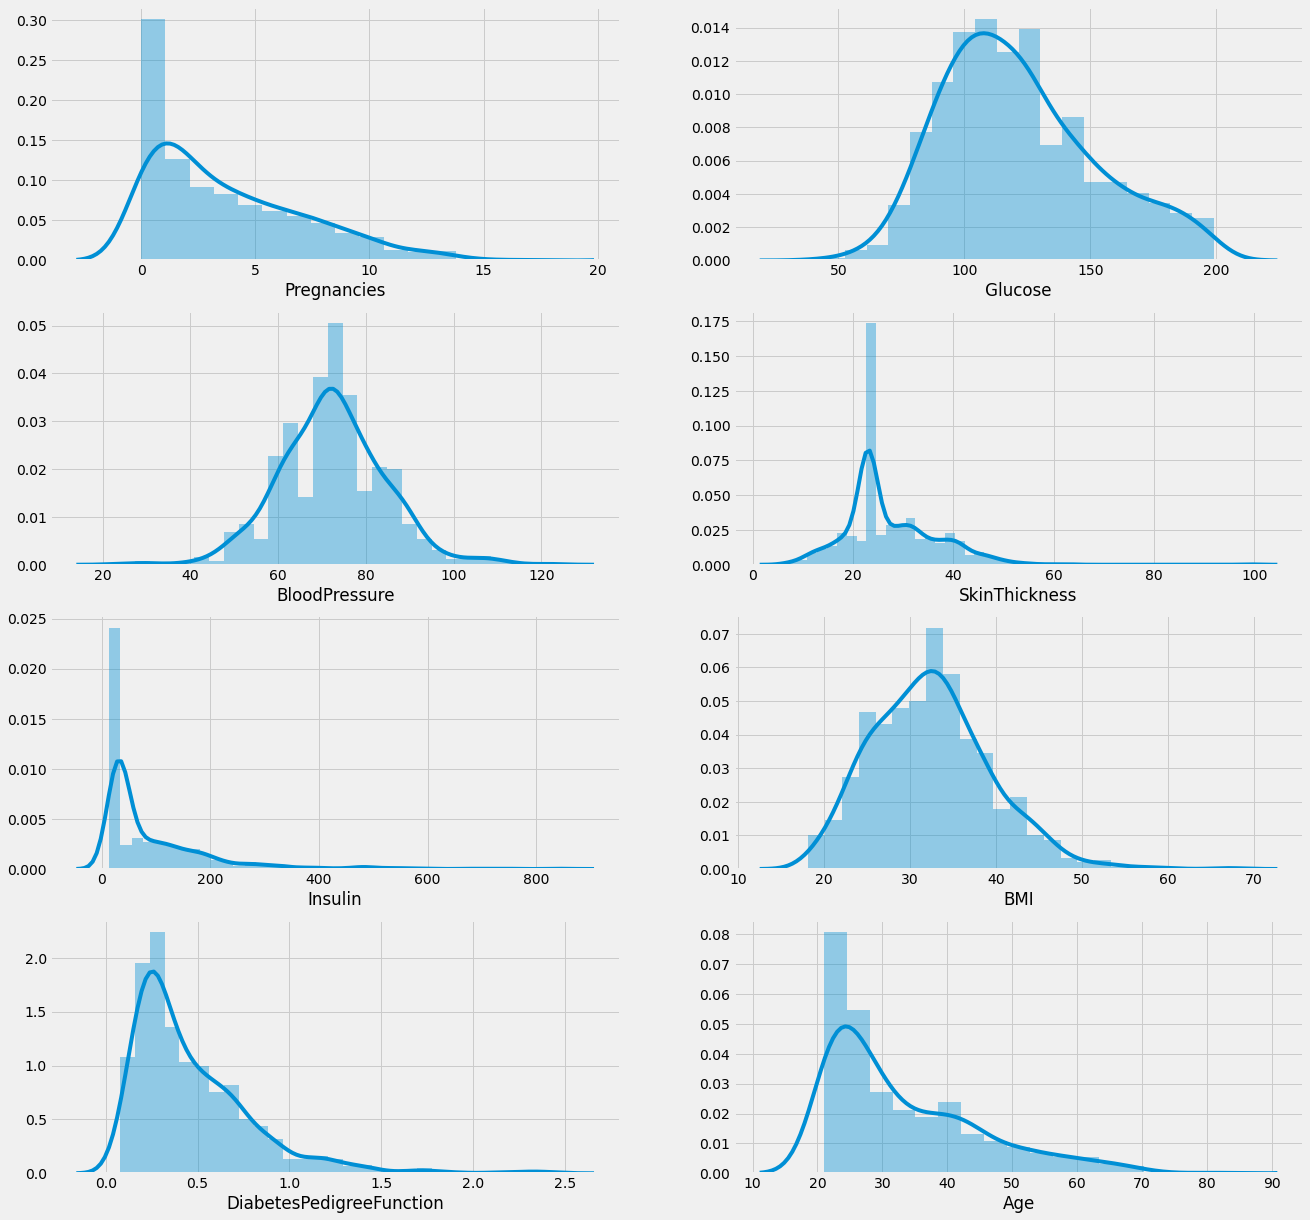

In [32]:
#gráficos sem 0
f, axes = plt.subplots(4,2, figsize=(20,20))
sns.distplot(diabetes.Pregnancies, ax=axes[0,0])
sns.distplot(diabetes.Glucose, ax=axes[0,1])
sns.distplot(diabetes.BloodPressure, ax=axes[1,0])
sns.distplot(diabetes.SkinThickness, ax=axes[1,1])
sns.distplot(diabetes.Insulin, ax=axes[2,0])
sns.distplot(diabetes.BMI, ax=axes[2,1])
sns.distplot(diabetes.DiabetesPedigreeFunction, ax=axes[3,0])
sns.distplot(diabetes.Age, ax=axes[3,1])



---



---



#Construção da rede 

Preparação dos dados

In [0]:
#separando em treino e teste

X = diabetes.drop('Outcome', axis =1).values
y = diabetes.Outcome.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)


In [0]:
#normalizando

nl = Normalizer()
nl.fit(X_train)
X_train = nl.transform(X_train)
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2)
X_dev = nl.transform(X_dev)
X_test = nl.transform(X_test)

In [0]:
#configurando a arquitetura da rede

inputs = Input(name='inputs', shape=[X_train.shape[1],])
layer = Dense(128, name='FC1')(inputs)
layer = BatchNormalization(name='BC1')(layer)
layer = Activation('relu', name='Activation1')(layer)
layer = Dropout(0.3, name='Dropout1')(layer)
layer = Dense(128, name='FC2')(layer)
layer = BatchNormalization(name='BC2')(layer)
layer = Activation('relu', name='Activation2')(layer)
layer = Dropout(0.3, name='Dropout2')(layer)
layer = Dense(128, name='FC3')(layer)
layer = BatchNormalization(name='BC3')(layer)
layer = Dropout(0.3, name='Dropout3')(layer)
layer = Dense(1, name='OutLayer')(layer)
layer = Activation('sigmoid', name='sigmoid')(layer)
model = Model(inputs=inputs, outputs=layer)


In [41]:
#resumo do modelo
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 8)                 0         
_________________________________________________________________
FC1 (Dense)                  (None, 128)               1152      
_________________________________________________________________
BC1 (BatchNormalization)     (None, 128)               512       
_________________________________________________________________
Activation1 (Activation)     (None, 128)               0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 128)               0         
_________________________________________________________________
FC2 (Dense)                  (None, 128)               16512     
_________________________________________________________________
BC2 (BatchNormalization)     (None, 128)               512 

In [0]:
#compilando o modelo

model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [0]:
#adicionando callbacks
reduce_lr = ReduceLROnPlateau()
early_stopping = EarlyStopping(patience=20, min_delta=0.0001)

In [50]:
#fit
model.fit(x=X_train, y=y_train, epochs=1000, validation_data=(X_dev, y_dev), callbacks=[reduce_lr, early_stopping], verbose=0)

In [51]:
#métricas
x_lst = [X_train, X_dev, X_test]
y_lst = [y_train, y_dev, y_test]
for i,(x,y) in enumerate(zip(x_lst, y_lst)):
    y_pred = model.predict(x)
    y_pred = np.around(y_pred)
    y_pred = np.asarray(y_pred)
    if i == 0:
        print('Training set:')
        print('\tAccuracy:{:0.3f}\n\tClassification Report\n{}'.format(accuracy_score(y, y_pred), 
                                                                  classification_report(y, y_pred)))
    elif i == 1:
        print('Dev set:')
        print('\tAccuracy:{:0.3f}\n\tClassification Report\n{}'.format(accuracy_score(y, y_pred), 
                                                                  classification_report(y, y_pred)))
    else:
        print('Test set:')
        print('\tAccuracy:{:0.3f}\n\tClassification Report\n{}'.format(accuracy_score(y, y_pred), 
                                                                  classification_report(y, y_pred)))

Training set:
	Accuracy:0.771
	Classification Report
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       345
           1       0.72      0.59      0.65       192

    accuracy                           0.77       537
   macro avg       0.76      0.73      0.74       537
weighted avg       0.77      0.77      0.76       537

Dev set:
	Accuracy:0.730
	Classification Report
              precision    recall  f1-score   support

           0       0.81      0.82      0.81        82
           1       0.53      0.52      0.52        33

    accuracy                           0.73       115
   macro avg       0.67      0.67      0.67       115
weighted avg       0.73      0.73      0.73       115

Test set:
	Accuracy:0.681
	Classification Report
              precision    recall  f1-score   support

           0       0.70      0.88      0.78        73
           1       0.62      0.35      0.45        43

    accuracy                    

Para esta arquitetura de rede, o modelo mostrou um desempenho ruim enquanto previa os casos positivos na tanto no conjunto de validação quanto no conjunto de testes